In [4]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import collections
import numpy as np
import json
import tweepy as tw
import nltk
import matplotlib.cm as cm
from nltk.corpus import stopwords
from nltk import bigrams
import re
import networkx as nx
import igraph
import warnings
import community as community_louvain
warnings.filterwarnings("ignore")

In [5]:
network_data = pd.read_csv("./dataset/network_data.csv")
network_data

,author_id,Source_author_id,weight,ifmis
0,1000017692211011587,1279751512785371138,1,1
1,1000027408508977152,177564016,1,1
2,1000029361054109697,429251479,2,1
3,1000080602815582208,1245651935706808321,1,1
4,1000088732836532229,1205638720457715713,1,1
...,...,...,...,...
175196,1357405807994753024,1257348234676260866,1,0
175197,1357406696390418434,61660254,1,0
175198,1357408407586820097,79293791,1,0
175199,1357408718082748416,2198363538,1,0


In [7]:
id1=network_data.author_id.unique().tolist()
id2=network_data.Source_author_id.unique().tolist()
id3=id1+id2
id4 = list(set(id3)) 
dic_id = {id4[i]:i for i in range(len(id4))}
def apply_id(x):
    index=dic_id[x]
    return index

network_data["author_id"] = network_data["author_id"].apply(apply_id)
network_data["Source_author_id"] = network_data["Source_author_id"].apply(apply_id)
network_data.sort_values("author_id",inplace=True)
network_data

,author_id,Source_author_id,weight,ifmis
119224,0,60102,1,1
104829,1,60102,1,1
110915,2,74674,1,1
111682,3,50711,1,1
111683,3,128863,1,1
...,...,...,...,...
161271,144621,84685,1,0
161272,144621,31899,1,0
130518,144621,90734,1,1
150475,144622,11890,1,0


In [8]:
G = nx.from_pandas_edgelist(network_data, 'author_id', 'Source_author_id', ["weight","ifmis"], create_using = nx.DiGraph())
network_data['ifmis'].value_counts()

1    130775
0     44426
Name: ifmis, dtype: int64

In [9]:
print("Number of G nodes:",G.number_of_nodes())
print("Number of G edges:",G.size())


Number of G nodes: 144624
Number of G edges: 175130


In [10]:
G_componrnts=nx.strongly_connected_components(G)
largest_components=max(G_componrnts,key=len)
subgraph_nodes=list(largest_components)
G_subgraph=G.subgraph(subgraph_nodes)
H=G_subgraph.to_undirected()
print("Number of g nodes:",H.number_of_nodes())
print("Number of g edges:",H.size())

Number of g nodes: 1362
Number of g edges: 3938


In [11]:
df_small = nx.to_pandas_edgelist(H)
id1=df_small.source.unique().tolist()
id2=df_small.target.unique().tolist()
id3=id1+id2
id4 = list(set(id3)) 
dic_id = {id4[i]:i for i in range(len(id4))}
df_small["source"] = df_small["source"] .apply(apply_id)
df_small["target"]  = df_small["target"].apply(apply_id)
df_small.sort_values("source",inplace=True)
df_small['ifmis'].value_counts()


1    3877
0      61
Name: ifmis, dtype: int64

In [12]:
len(id4)

1362

In [30]:
def setnode_lable(data):
    df_node1 = data.groupby(['source'])['ifmis'].mean()
    df_node2 = data.groupby(['target'])['ifmis'].mean()
    df_node1 = pd.DataFrame(df_node1)
    df_node1 = df_node1.reset_index()
    new_col = ['node', 'lable']
    df_node1.columns = new_col
    df_node2 = pd.DataFrame(df_node2)
    df_node2 = df_node2.reset_index()
    df_node2.columns = new_col
    df_node = pd.merge(df_node1,df_node2,on='node',how='outer') 
    df_node['lable_x'].fillna(0, inplace=True)
    df_node['lable_y'].fillna(0, inplace=True)
    df_node['lable']=df_node['lable_x']+df_node['lable_y']
    df_node = df_node[['node','lable']]
    df_node['lable'].astype('int')
    return df_node
df_node = setnode_lable(df_small)
df_node

,node,lable
0,0,1.000000
1,1,1.000000
2,2,2.000000
3,3,1.000000
4,4,1.000000
...,...,...
1357,1356,1.000000
1358,1357,0.833333
1359,1358,1.000000
1360,1360,1.000000


In [31]:
def setlable(x):
    if x<1:
        return 1
    elif x==0:
        return 0
    else:
        return 2

df_node["lable1"] = df_node["lable"] .apply(setlable)
lable_id=df_node.lable.unique().tolist()
lable_id = list(set(lable_id)) 
dic_id = {lable_id[i]:i for i in range(len(lable_id))}
df_node["lable2"] = df_node["lable"].apply(apply_id)
df_node

,node,lable,lable1,lable2
0,0,1.000000,2,1
1,1,1.000000,2,1
2,2,2.000000,2,2
3,3,1.000000,2,1
4,4,1.000000,2,1
...,...,...,...,...
1357,1356,1.000000,2,1
1358,1357,0.833333,1,28
1359,1358,1.000000,2,1
1360,1360,1.000000,2,1


In [10]:
G=G.to_undirected()
g = nx.from_pandas_edgelist(df_small, 'source', 'target', ['weight','ifmis'])

In [11]:
print("Number of G nodes:",G.number_of_nodes())
print("Number of G edges:",G.size())
print("Number of g nodes:",g.number_of_nodes())
print("Number of g edges:",g.size())


Number of G nodes: 144624
Number of G edges: 173785
Number of g nodes: 1362
Number of g edges: 3938


In [ ]:
df_node['lable1'].value_counts()

In [ ]:
df_node['lable1'].value_counts()

# Louvain

In [32]:
partition1 = community_louvain.best_partition(g)
df1=pd.DataFrame.from_dict(list(partition1.items()))
new_col = ['node', 'Louvain_lable']
df1.columns = new_col
df1.sort_values(by='node',inplace=True)
df_node = pd.merge(df_node,df1,on='node',how='outer')
df_node

,node,lable,lable1,lable2,Louvain_lable
0,0,1.000000,2,1,0
1,1,1.000000,2,1,1
2,2,2.000000,2,2,0
3,3,1.000000,2,1,23
4,4,1.000000,2,1,3
...,...,...,...,...,...
1357,1356,1.000000,2,1,0
1358,1357,0.833333,1,28,6
1359,1358,1.000000,2,1,0
1360,1360,1.000000,2,1,17


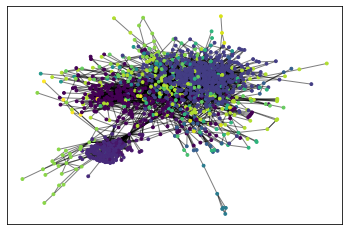

Cluster number of g: 18


In [13]:
def drawgraph(g,menberships):# draw the graph
    pos = nx.spring_layout(g)
    # color the nodes according to their partition
    cmap = cm.get_cmap('viridis', max(menberships.values()) + 1)
    nx.draw_networkx_nodes(g, pos, menberships.keys(), node_size=8,
                           cmap=cmap, node_color=list(menberships.values()))
    nx.draw_networkx_edges(g, pos, alpha=0.5)
    plt.show()
drawgraph(g,partition1)
print("Cluster number of g:",1+max(partition1.values()))

# GEMSEC

In [14]:
from karateclub import GEMSEC
GEMSEC_g = GEMSEC()
GEMSEC_g.fit(g)
partition2 = GEMSEC_g.get_memberships()

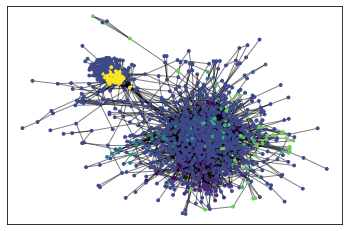

Cluster number of g: 10


In [15]:
drawgraph(g,partition2)
print("Cluster number of g:",1+max(partition2.values()))

In [33]:
df2=pd.DataFrame.from_dict(list(partition2.items()))
new_col = ['node', 'GEMSEC_lable']
df2.columns = new_col
df2.sort_values(by='node',inplace=True)
df_node = pd.merge(df_node,df2,on='node',how='outer')
df_node

,node,lable,lable1,lable2,Louvain_lable,GEMSEC_lable
0,0,1.000000,2,1,0,1
1,1,1.000000,2,1,1,2
2,2,2.000000,2,2,0,2
3,3,1.000000,2,1,23,6
4,4,1.000000,2,1,3,2
...,...,...,...,...,...,...
1357,1356,1.000000,2,1,0,2
1358,1357,0.833333,1,28,6,2
1359,1358,1.000000,2,1,0,2
1360,1360,1.000000,2,1,17,2


# EdMot

In [17]:
from karateclub import EdMot
EdMot_g = EdMot()
EdMot_g.fit(g)
partition3 = EdMot_g.get_memberships()


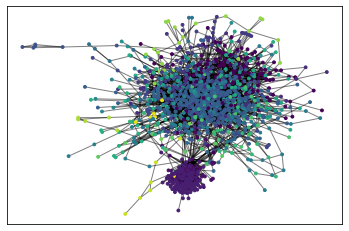

Cluster number of g: 25


In [18]:
drawgraph(g,partition3)
print("Cluster number of g:",1+max(partition3.values()))

In [34]:
df3=pd.DataFrame.from_dict(list(partition3.items()))
new_col = ['node', 'EdMot_lable']
df3.columns = new_col
df3.sort_values(by='node',inplace=True)
df_node = pd.merge(df_node,df3,on='node',how='outer')
df_node

,node,lable,lable1,lable2,Louvain_lable,GEMSEC_lable,EdMot_lable
0,0,1.000000,2,1,0,1,0
1,1,1.000000,2,1,1,2,1
2,2,2.000000,2,2,0,2,3
3,3,1.000000,2,1,23,6,5
4,4,1.000000,2,1,3,2,7
...,...,...,...,...,...,...,...
1357,1356,1.000000,2,1,0,2,0
1358,1357,0.833333,1,28,6,2,7
1359,1358,1.000000,2,1,0,2,0
1360,1360,1.000000,2,1,17,2,10


# SCD

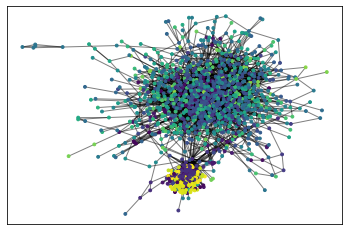

Cluster number of g: 889


In [20]:
from karateclub import SCD
SCD_g = SCD()
SCD_g.fit(g)
partition4= SCD_g.get_memberships()
drawgraph(g,partition4)
print("Cluster number of g:",1+max(partition4.values()))

In [35]:
df4=pd.DataFrame.from_dict(list(partition4.items()))
new_col = ['node', 'SCD_lable']
df4.columns = new_col
df4.sort_values(by='node',inplace=True)
df_node = pd.merge(df_node,df4,on='node',how='outer')
df_node

,node,lable,lable1,lable2,Louvain_lable,GEMSEC_lable,EdMot_lable,SCD_lable
0,0,1.000000,2,1,0,1,0,196
1,1,1.000000,2,1,1,2,1,881
2,2,2.000000,2,2,0,2,3,734
3,3,1.000000,2,1,23,6,5,195
4,4,1.000000,2,1,3,2,7,733
...,...,...,...,...,...,...,...,...
1357,1356,1.000000,2,1,0,2,0,285
1358,1357,0.833333,1,28,6,2,7,238
1359,1358,1.000000,2,1,0,2,0,275
1360,1360,1.000000,2,1,17,2,10,266


# LabelPropagation

In [23]:
from karateclub import LabelPropagation
LabelPropagation_g = LabelPropagation()
LabelPropagation_g.fit(g)
partition5 = LabelPropagation_g.get_memberships()


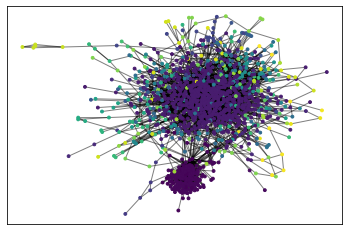

Cluster number of g: 1345


In [24]:
drawgraph(g,partition5)
print("Cluster number of g:",1+max(partition5.values()))

In [36]:
df5=pd.DataFrame.from_dict(list(partition5.items()))
new_col = ['node', 'LabelPropagation_lable']
df5.columns = new_col
df5.sort_values(by='node',inplace=True)
df_node = pd.merge(df_node,df5,on='node',how='outer')
df_node

,node,lable,lable1,lable2,Louvain_lable,GEMSEC_lable,EdMot_lable,SCD_lable,LabelPropagation_lable
0,0,1.000000,2,1,0,1,0,196,666
1,1,1.000000,2,1,1,2,1,881,37
2,2,2.000000,2,2,0,2,3,734,402
3,3,1.000000,2,1,23,6,5,195,118
4,4,1.000000,2,1,3,2,7,733,118
...,...,...,...,...,...,...,...,...,...
1357,1356,1.000000,2,1,0,2,0,285,488
1358,1357,0.833333,1,28,6,2,7,238,118
1359,1358,1.000000,2,1,0,2,0,275,1258
1360,1360,1.000000,2,1,17,2,10,266,464


# Modularity


In [26]:
import community

In [37]:
print("Louvain Modularity1:",community.modularity(partition1,g))
print("Louvain Modularity2:",community.modularity(partition1,g))
print("GEMSEC Modularity1:",community.modularity(partition2,g))
print("GEMSEC Modularity2:",community.modularity(partition2,g))
print("EdMot Modularity1:",community.modularity(partition3,g))
print("EdMot Modularity2:",community.modularity(partition3,g))
print("SCD Modularity1:",community.modularity(partition4,g))
print("SCD Modularity2:",community.modularity(partition4,g))
print("LabelPropagation Modularity1:",community.modularity(partition5,g))
print("LabelPropagation Modularity2:",community.modularity(partition5,g))

Louvain Modularity1: 0.6714395526665553
Louvain Modularity2: 0.6714395526665553
GEMSEC Modularity1: 0.38479232398694085
GEMSEC Modularity2: 0.38479232398694085
EdMot Modularity1: 0.6697758436348225
EdMot Modularity2: 0.6697758436348225
SCD Modularity1: 0.4717797467572834
SCD Modularity2: 0.4717797467572834
LabelPropagation Modularity1: 0.4720131212713631
LabelPropagation Modularity2: 0.4720131212713631


# Purity

In [28]:
from sklearn.metrics import accuracy_score
import numpy as np

def purity_score(y_true, y_pred):
    """Purity score
        Args:
            y_true(np.ndarray): n*1 matrix Ground truth labels
            y_pred(np.ndarray): n*1 matrix Predicted clusters

        Returns:
            float: Purity score
    """
    # matrix which will hold the majority-voted labels
    y_voted_labels = np.zeros(y_true.shape)
    # Ordering labels
    ## Labels might be missing e.g with set like 0,2 where 1 is missing
    ## First find the unique labels, then map the labels to an ordered set
    ## 0,2 should become 0,1
    labels = np.unique(y_true)
    ordered_labels = np.arange(labels.shape[0])
    for k in range(labels.shape[0]):
        y_true[y_true==labels[k]] = ordered_labels[k]
    # Update unique labels
    labels = np.unique(y_true)
    # We set the number of bins to be n_classes+2 so that 
    # we count the actual occurence of classes between two consecutive bins
    # the bigger being excluded [bin_i, bin_i+1[
    bins = np.concatenate((labels, [np.max(labels)+1]), axis=0)

    for cluster in np.unique(y_pred):
        hist, _ = np.histogram(y_true[y_pred==cluster], bins=bins)
        # Find the most present label in the cluster
        winner = np.argmax(hist)
        y_voted_labels[y_pred==cluster] = winner

    return accuracy_score(y_true, y_voted_labels)


In [38]:
print("Louvain Purity1:",purity_score(df_node.lable1.values,df_node.Louvain_lable.values))
print("Louvain Purity2:",purity_score(df_node.lable2.values,df_node.Louvain_lable.values))
print("GEMSEC Purity1:",purity_score(df_node.lable1.values,df_node.GEMSEC_lable.values))
print("GEMSEC Purity2:",purity_score(df_node.lable2.values,df_node.GEMSEC_lable.values))
print("EdMot Purity1:",purity_score(df_node.lable1.values,df_node.EdMot_lable.values))
print("EdMot Purity2:",purity_score(df_node.lable2.values,df_node.EdMot_lable.values))
print("SCD Purity1:",purity_score(df_node.lable1.values,df_node.SCD_lable.values))
print("SCD Purity2:",purity_score(df_node.lable2.values,df_node.SCD_lable.values))
print("LabelPropagation Purity1:",purity_score(df_node.lable1.values,df_node.LabelPropagation_lable.values))
print("LabelPropagation Purity2:",purity_score(df_node.lable2.values,df_node.LabelPropagation_lable.values))

Louvain Purity1: 0.9772393538913363
Louvain Purity2: 0.5521292217327459
GEMSEC Purity1: 0.9772393538913363
GEMSEC Purity2: 0.5256975036710719
EdMot Purity1: 0.9772393538913363
EdMot Purity2: 0.5425844346549192
SCD Purity1: 0.9860499265785609
SCD Purity2: 0.7687224669603524
LabelPropagation Purity1: 0.9772393538913363
LabelPropagation Purity2: 0.591776798825257


# NMI

In [39]:
import math
from sklearn import metrics
def NMI(A,B):
    # 样本点数
    total = len(A)
    A_ids = set(A)
    B_ids = set(B)
    # 互信息计算
    MI = 0
    eps = 1.4e-45
    for idA in A_ids:
        for idB in B_ids:
            idAOccur = np.where(A==idA)    # 输出满足条件的元素的下标
            idBOccur = np.where(B==idB)
            idABOccur = np.intersect1d(idAOccur,idBOccur)   # Find the intersection of two arrays.
            px = 1.0*len(idAOccur[0])/total
            py = 1.0*len(idBOccur[0])/total
            pxy = 1.0*len(idABOccur)/total
            MI = MI + pxy*math.log(pxy/(px*py)+eps,2)
    # 标准化互信息
    Hx = 0
    for idA in A_ids:
        idAOccurCount = 1.0*len(np.where(A==idA)[0])
        Hx = Hx - (idAOccurCount/total)*math.log(idAOccurCount/total+eps,2)
        Hy = 0
    for idB in B_ids:
        idBOccurCount = 1.0*len(np.where(B==idB)[0])
        Hy = Hy - (idBOccurCount/total)*math.log(idBOccurCount/total+eps,2)
    MIhat = 2.0*MI/(Hx+Hy)
    return MIhat
 
print("Louvain NMI1:",NMI(df_node.lable1.values,df_node.Louvain_lable.values))
print("Louvain NMI2:",NMI(df_node.lable2.values,df_node.Louvain_lable.values))
print("GEMSEC NMI1:",NMI(df_node.lable1.values,df_node.GEMSEC_lable.values))
print("GEMSEC NMI2:",NMI(df_node.lable2.values,df_node.GEMSEC_lable.values))
print("EdMot NMI1:",NMI(df_node.lable1.values,df_node.EdMot_lable.values))
print("EdMot NMI2:",NMI(df_node.lable2.values,df_node.EdMot_lable.values))
print("SCD NMI1:",NMI(df_node.lable1.values,df_node.SCD_lable.values))
print("SCD NMI2:",NMI(df_node.lable2.values,df_node.SCD_lable.values))
print("LabelPropagation NMI1:",NMI(df_node.lable1.values,df_node.LabelPropagation_lable.values))
print("LabelPropagation NMI2:",NMI(df_node.lable2.values,df_node.LabelPropagation_lable.values))

Louvain NMI1: 0.013456062842569698
Louvain NMI2: 0.05446176464337089
GEMSEC NMI1: 0.005882216629029038
GEMSEC NMI2: 0.05853490657350784
EdMot NMI1: 0.014856124015941103
EdMot NMI2: 0.055705274886704355
SCD NMI1: 0.02560444770437647
SCD NMI2: 0.1700254955067765
LabelPropagation NMI1: 0.01660000196439597
LabelPropagation NMI2: 0.07773365177239419


# ARI (Adjusted Rand index)

In [40]:
print("Louvain ARI1:",metrics.adjusted_rand_score(df_node.lable1.values,df_node.Louvain_lable.values))
print("Louvain ARI2:",metrics.adjusted_rand_score(df_node.lable2.values,df_node.Louvain_lable.values))
print("GEMSEC ARI1:",metrics.adjusted_rand_score(df_node.lable1.values,df_node.GEMSEC_lable.values))
print("GEMSEC ARI2:",metrics.adjusted_rand_score(df_node.lable2.values,df_node.GEMSEC_lable.values))
print("EdMot ARI1:",metrics.adjusted_rand_score(df_node.lable1.values,df_node.EdMot_lable.values))
print("EdMot ARI2:",metrics.adjusted_rand_score(df_node.lable2.values,df_node.EdMot_lable.values))
print("SCD ARI1:",metrics.adjusted_rand_score(df_node.lable1.values,df_node.SCD_lable.values))
print("SCD ARI2:",metrics.adjusted_rand_score(df_node.lable2.values,df_node.SCD_lable.values))
print("LabelPropagation ARI1:",metrics.adjusted_rand_score(df_node.lable1.values,df_node.LabelPropagation_lable.values))
print("LabelPropagation ARI2:",metrics.adjusted_rand_score(df_node.lable2.values,df_node.LabelPropagation_lable.values))

Louvain ARI1: -0.0050529167887012364
Louvain ARI2: -0.002377338932462378
GEMSEC ARI1: -0.018495733838048065
GEMSEC ARI2: -0.0071237506770803136
EdMot ARI1: -4.761430357710787e-05
EdMot ARI2: -0.0013748417842416828
SCD ARI1: 8.660318846664786e-05
SCD ARI2: 0.0008800970632714061
LabelPropagation ARI1: -0.00964658303744041
LabelPropagation ARI2: -0.011514184482999575
